In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck 
import scipy
from scipy.special import sph_harm
from ase.io import read
from ase import neighborlist
from ase.visualize import view
from pylab import * 

##### plot preferences

In [37]:

SMALL_SIZE = 8   #8
MEDIUM_SIZE = 12 #20
BIGGER_SIZE = 12 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

##### Read and visualize trajectory

In [38]:
trajectory = read('trajectory.xyz', index=':')

In [39]:
view(trajectory)

##### integrated path length

we represent the path as function of the integrated path length, s, defined as follows:

$$
s = \sum_m \vert \vec R (m+1) - \vec R(m)\vert 
$$

this parameter provides a measure of the separation between local minima.

In [40]:
integrated_path_length = np.zeros(len(trajectory))

for m in range(1,len(trajectory)):
    integrated_path_length[m] = integrated_path_length[m-1]+np.linalg.norm(trajectory[m].get_positions()-trajectory[m-1].get_positions())

#in sigma units
integrated_path_length/=3.405


##### Compute $Q_l$ with $l=6$

We define local bond order parameters, or Steinhardt order parameters, as:

$$
q_{lm} = \frac{1}{N_{bonds}} \sum_{N_n} y_{lm} (\theta_{ij}, \phi_{ij})
\qquad
 with:
 \quad
Q_l^2 = \frac{4 \pi}{2l+1} \sum_{m=-l}^l |q_{lm}|^2 .
$$

These parameters hold the information of the local structure and, depending on the choice of l, they are sensitive to different symmetries. $Q_4$ and $Q_6$ well discriminate between cubic and hexagonal structures.

We first define a general python function for $Q_l$ calculation, and then compute $Q_6$ just calling the function.

In [41]:
def QL(l):
    
    rcut = 3.405*1.391/2 #in Angstrom
    
    #update the cutoff for each frame
    for frame in trajectory: 
        array_rcut         = np.ones(len(frame))*rcut
        new_neighbour_list = neighborlist.NeighborList(array_rcut,skin=0, self_interaction=False, bothways=False)
        new_neighbour_list.update(frame)
    
    
    #compute Ql for each frame
    Ql = np.empty(len(trajectory))
    i  = 0
    
    for frame in trajectory:
        nbonds = 0
        qlm    = np.zeros(2*l+1) 
        
        for atom in frame:
            nlist = new_neighbour_list.get_neighbors(atom.index)[0]
                
            for theneig in nlist:   #cycle over the neighbours
                #get angles and distances
                nbonds   = nbonds+1
                rij      = frame[theneig].position - atom.position
                dist     = np.linalg.norm(rij)
                phi_ij   = np.arccos(rij[2]/dist)
                theta_ij = np.arctan2(rij[1],rij[0])
                if theta_ij < 0:
                    theta_ij += 2*np.pi
                
                #move in spherical coordinates space
                    # In a like-oriented coordinate system at j,
                    #the spherical coordinates of atom i are:
                if theta_ij  <= np.pi:
                    theta_ji  = theta_ij + np.pi
                elif theta_ij > np.pi:
                    theta_ji  = theta_ij - np.pi
                if np.absolute(theta_ji-2*np.pi)<0.0001:
                    theta_ji=0.0
                phi_ji = np.pi-phi_ij
                
                #compute spherical harmonics and perform qml summation 
                qlm = qlm + np.array([ sph_harm(m,l,theta_ij,phi_ij) for m in range(-l,l+1) ])
                
        qlm   =  np.real(qlm*np.conj(qlm)/(nbonds*nbonds))
        #prefactor and second summation
        Ql[i] =  np.sqrt(np.pi *4 /(2*l+1)*np.sum(qlm))
        i    += 1
    return Ql;
    

In [42]:
Q6 = QL(6)

##### Compute asphericity

Asphericity is another descriptor parameter for clusters. It is 

In [43]:
I = np.empty([0,3])
for frame in trajectory:
    I = np.append(I,[frame.get_moments_of_inertia()],axis=0)

I = I.transpose()
asph = ((I[0]- I[1])**2 + (I[0]- I[2])**2 + (I[2]- I[1])**2 )/ (I[0]**2 + I[1]**2 + I[2]**2)

##### Energy representation

heigh of the barrier:   0.38445600575101935 V/ε


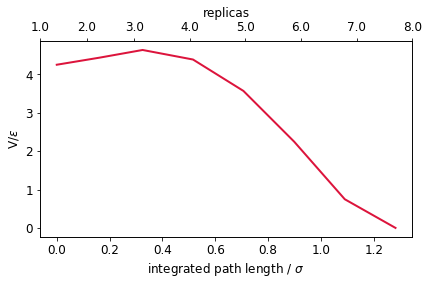

In [44]:
energy     = np.loadtxt('energy.dat')
energy     = np.transpose(energy)
#epsilon/kB =119.8 K      KB = 8.616733e-5 eV/K 
epsilon    = 119.8*8.616733e-5 #K * eV/K = eV
energy[1] *= 27.1442/epsilon #eV / epsilon(eV)
min_e      = np.min(energy[1])
energy[1] -= min_e

fig = plt.plot(integrated_path_length,energy[1],color='crimson', lw=2)
#get the axis just defined
ax  = plt.gca()
ax.set_ylabel("V/$\epsilon$")
ax.set_xlabel("integrated path length / $\sigma$")

# ---- create a second axis (ax2) ----

#  axis ticks
vec_tick        = np.empty(0)
vec_tick_values = np.empty(0)
for i in range (0,len(integrated_path_length)): 
    # plot energy values
    vec_tick_values = np.append(vec_tick_values,round(energy[0][i],2))
    #in the positions are identified according to the integrated path length values
    vec_tick = np.append(vec_tick,integrated_path_length[i])    
ax2 = ax.twiny() 
ax2.set_xticks(vec_tick)
ax2.set_xticklabels(vec_tick_values)
ax2.set_xlabel("replicas")

plt.tight_layout()
#plt.savefig("NEB_energy.png", dpi=400,transparent=True)
print('heigh of the barrier:  ', np.max(energy[1])-energy[1][0], 'V/ε')
plt.show()



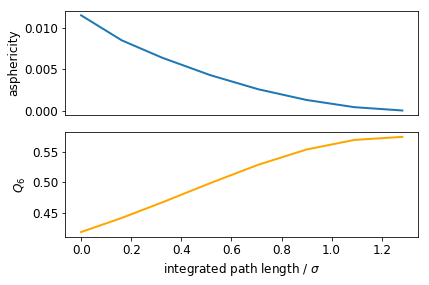

In [45]:
fig, ax = plt.subplots(2,1,sharex='col',squeeze ='False')


#FIRST PLOT
ax[0].plot(integrated_path_length,asph, lw=2)
ax[0].xaxis.set_ticks_position('none')
ax[0].set_ylabel("asphericity")

#THIRD PLOT
ax[1].plot(integrated_path_length,Q6, color = 'orange',lw=2)
ax[1].set_xlabel("integrated path length / $\sigma$")
ax[1].set_ylabel("$Q_6$")

plt.subplots_adjust( hspace=1)
plt.tight_layout()
#plt.savefig("NEB_order_parameters.png",  dpi=300,transparent=True)
plt.show()

   